![](https://classteaching.files.wordpress.com/2017/10/words.jpg)
<h1 style="text-align: center;">Word Analysis within an Author's Collection of Works</h1>
<h3> <a href="https://github.com/ErosLSmith/TextAnalysis/tree/master">Full Project Link in Github</a></h3>
<p>This will be a casual exploration of large bodies of text by way of data analysis in effort to glean insights into the author, the text itself, and even the use of language that not would not be afforded by other means. </p>
<h2>Data Rangling </h2>
<p>Starting with the raw text of the combined works of the author Edgar Allen Poe from volumns one through four on <a href="http://www.gutenberg.org" >Project Gutenburg</a>, it seemed looking at word counts is an obvious first step at wrapping my mind around the text as data. In effort of reducing the noise of <a href="https://en.wikipedia.org/wiki/Stop_words" >stopwords</a> along with the excitement of adding a new dimension to the represention of the data, words were also filtered based on their part of speech. Dividing all the words up based on whether they are nouns, adjectives, adverbs and verbs seemed like the logical place to start looking for word significance and meaningful relationships within the textual body. Also since the data is a combined set of works, it seemed important to note the position of a word within the orginal text, so arrays containing the postitions of each word needed to be added to the dataset of wordcounts. After looking at the density charts, the idea of ordering the works seemed like it would add extra meaning within the density analysis.</p>
<p>A second and more complete source for Edgar Allen Poes's works was found at <a href="https://books.eserver.org/placeholder-poe">books.eserver.org</a> and were extracted using <a href="https://www.crummy.com/software/BeautifulSoup/">Beautiful Soup</a>. Using the wikipedia page with <a href="https://en.wikipedia.org/wiki/Edgar_Allan_Poe_bibliography">Poe's bibliograghy</a>, the works were conjointed with their publishing date and genre. The works were then reordered with this information to check for trends based on these added data points.</p> 

In [63]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import re
from plotly import tools
from plotly import offline
import plotly.plotly as py
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set(color_codes=True)

offline.init_notebook_mode()
inKaggle = False

DATA_FOLDERS = {}
if inKaggle:
    DATA_FOLDERS = {"noun": "../input/nouns-counts-in-the-works-of-edgar-allan-poe/nouncount.txt",
                            "adjective": "../input/adjective-counts-in-the-works-of-edgar-allan-poe/adjectivecount.txt"
                          }
else:
    cwd = os.getcwd()
    DATA_FOLDERS = {"noun": cwd + "/noun_counts.txt/nouncount.txt",
                            "adjective": cwd + "/adjective_counts.txt/adjectivecount.txt"
                          }
        

In [83]:

def mlist(row):
    try:
        ints = [int(i) for i in re.sub(r'[\]\[()]', '', row[1]).split(", ")]
    except:
        print(row)
    return ints


def llist(row):
    ints = [int(i) for i in re.sub(r'[\]\[()]', '', row[1]).split(", ")[1:]]
    int_pairs = []
    for i in range(0, len(ints), 2):
        pair = [ints[i],ints[i + 1]]
        pair.sort()
        int_pairs.append(pair[1]) 
    return int_pairs

def llistpair(row):
    ints = [int(i) for i in re.sub(r'[\]\[()]', '', row[1]).split(", ")[1:]]
    int_pairs = []
    for i in range(0, len(ints), 2):
        pair = [ints[i],ints[i + 1]]
        pair.sort()
        int_pairs.append((pair[0], pair[1])) 
    return int_pairs

def getCount(row):
    count = row[2][0]
    return count


def getDesityCounts(theRange, incrementSize, values):
    startValue = theRange[0]
    stopValue = theRange[1]
    counts = []
    interval = [startValue, startValue + incrementSize]
    i = 0
    while interval[1] <= stopValue:
        count = 0
        while i < len(values) and values[i] > interval[0] and\
                values[i] <= interval[1]:
            i = i + 1
            count = count + 1
        interval[0] = interval[1]
        interval[1] = interval[0] + incrementSize
        counts.append(count)
    return counts


def getTopAmountDataFrame(filename,amount=None):
    df = pd.read_csv(filename, header=None, sep="|",
                     names=['word', 'count', 'allnums','wordcount','locations', 'location_pairs'],
                     dtype={0: np.object_,
                            1: np.object_,
                            2: np.object_,
                            3: np.object_,
                            4: np.object_,
                            5: np.object_})
    for idx, row in df.iterrows():
        df.loc[idx,'allnums'] = mlist(row)
    for idx, row in df.iterrows():
        df.loc[idx,'wordcount'] = getCount(row)
    for idx, row in df.iterrows():
        df.loc[idx,'locations'] = np.array(llist(row))
    for idx, row in df.iterrows():
        df.loc[idx,'location_pairs'] = np.array(llistpair(row))
        
    df.drop(['allnums', 'count'], axis=1, inplace=True)
    df.rename(columns={'wordcount': 'count'}, inplace=True)
    df = df.sort_values(by=['count', 'word'],
                        ascending=False).reset_index(drop=True)
    if amount is not None:
        df = df[:amount]
    return df


def positionalPairingOfTwoArrays(rootPointArray, comparisonArray, forwardThreshold=0, backwardThreshold=0):
    result = []
    for i in range(len(rootPointArray)):
            for j in range(len(comparisonArray)):
                   root = rootPointArray[i]
                   sample = comparisonArray[j]
                   if sample <= (root + forwardThreshold) and sample > root:
                       result.append((root, sample))
                   if sample >= (root - backwardThreshold) and sample < root:
                       result.append((root, sample))

    return result

def getWordPairings(rootdf, comparisondf):
    resultdf = pd.DataFrame()
    for idxa, rootrow in rootdf.iterrows():
        for idxb, comprow in comparisondf.iterrows():
            rootPointArray = rootrow.locations
            comparisonArray = comprow.locations
            noun = rootrow.word
            adjective = comprow.word
            pairArray = positionalPairingOfTwoArrays(rootPointArray,comparisonArray,forwardThreshold=3)
            
            if len(pairArray)>0:
                columns=['noun','adjective','count', 'locations']
                row = [str(noun),str(adjective),int(len(pairArray)),np.array(pairArray)]
                dic = { columns[i]:[row[i]] for i in range(len(columns))}
                tempdf = pd.DataFrame(dic, columns=columns)
                resultdf = resultdf.append(tempdf)
    resultdf = resultdf.sort_values(by=['count'],
                        ascending=False).reset_index(drop=True)
    print(resultdf.head())
    return resultdf 

def getPosWordCountDataframe(pos, amount=None):
    directory = ""
    if inKaggle:
        kaggle_data_folders = {"noun": "../input/nouns-counts-in-the-works-of-edgar-allan-poe/nouncount.txt",
                                "adjective": "../input/adjective-counts-in-the-works-of-edgar-allan-poe/adjectivecount.txt",
                                "verb": "../input/verb-counts-in-the-works-of-edgar-allan-poe/verbcount.txt",
                               "abverb": "../input/adverb-counts-in-the-works-of-edgar-allan-poe/adverbcount.txt"

                              }
        directory = kaggle_data_folders[pos]
    else:
        cwd = os.getcwd()
        home_data_folders = {"noun": cwd + "/noun_counts.txt/nouncount.txt",
                                "adjective": cwd + "/adjective_counts.txt/adjectivecount.txt",
                             "verb": cwd + "/verb_counts.txt/verbcount.txt",
                             "adverb": cwd + "/adverb_counts.txt/adverbcount.txt"
                              }
        directory = home_data_folders[pos]
        
    amount = amount
    df = getTopAmountDataFrame(directory, amount)
    return df
    
                   
def drawPosWordCountsBarGraph(df, pos, amount, source):
    data = [go.Bar(y=df['count'],
                   x=df['word'],
                   marker=dict(colorscale='Viridis',
                   color=df['count']))]
    title = "Top " + str(amount) + " " + str(pos).capitalize() + "s in " + str(source).title() 
    layout = go.Layout(title=title,
                          xaxis=dict(
            autotick=False,
            ticks='outside',
            tick0=0,
            dtick=1,
            ticklen=8,
            tickwidth=4,
            tickcolor='#000'
                                )
                      )
    fig = go.Figure(data=data, layout=layout)
    filename = str(pos).capitalize() + "Counts.html"
    offline.iplot(fig, filename=filename)

def drawPosWordDensityGraph(df, pos, width, amount,max_x_value=1800000):
    height = -(-amount // width)

    fig, ax = plt.subplots(figsize=(20,40), ncols=width, nrows=height)

    left   =  0.0  # the left side of the subplots of the figure
    right  =  0.9  # the right side of the subplots of the figure
    bottom =  0.2  # the bottom of the subplots of the figure
    top    =  0.9  # the top of the subplots of the figure
    wspace =  0.3  # the amount of width reserved for blank space between subplots
    hspace =  0.9  # the amount of height reserved for white space between subplots

    # This function actually adjusts the sub plots using the above paramters
    plt.subplots_adjust(
        left    =  left, 
        bottom  =  bottom, 
        right   =  right, 
        top     =  top, 
        wspace  =  wspace, 
        hspace  =  hspace
    )

    # The amount of space above titles
    x_limit = max_x_value
    y_title_margin = 1.2
    colors = sns.color_palette(palette=None, n_colors=amount, desat=None)
    plt.rcParams["axes.labelsize"] = 1
    paper_rc = {'lines.linewidth': 3, 'lines.markersize': .2, 'xtick.labelsize': 3, 'ytick.labelsize': 3, 'axes.labelsize': 36,}                  
    sns.set_context(rc = paper_rc)  
    plt.suptitle("Density of " + str(pos).capitalize() + "s as They Appear in Text", fontsize=30, y=.93 , x=.4)
    plt.gca().set_xlim(0,x_limit)
    index = 0
    for i in range(height):
        for j in range(width):
            index = i * width + j
            ax[i][j].set_title(df.word[index], y = y_title_margin, fontsize=20)
            g = sns.distplot(df.iloc[index]['locations'], kde=True, hist=True ,rug=True,  ax=ax[i][j], color=colors[index])
            g.axes.set_xlim(0, x_limit)
            g.tick_params(labelsize=10)
            g.lines

def drawQuickAndDirtyScatterPlot(df, pos):
    x = np.array([])
    y = np.array([])

    for i in range(amount):
        locs = np.asarray(df.iloc[i]['locations'])
        y = np.append(y, df.iloc[i]['locations'])
        x = np.append(x, np.full(len(df.iloc[i]['locations'], ), i))


    # Create a trace
    trace = go.Scattergl(
        x=x,
        y=y,
        mode='markers',
        marker=dict(
            size='8',
            colorscale='Viridis',
            line = dict(width = 1),
            color=y
        )
    )
    labels = df['word']
    bandxaxis = go.XAxis(
        title="",
        range=[-1, len(labels)],
        showgrid=True,
        showline=True,
        ticks="inside",
        showticklabels=True,
        tickangle=90,
        mirror=False,
        linewidth=0.0,
        ticktext=labels,
        tickvals=[i for i in range(len(labels))]
    )
    bandyaxis = go.YAxis(
        title="Placement of " + str(pos).capitalize() + "s in Text by Word Count",
        domain=[0,365000]
    )
    layouttitle = "Quick and Dirty Scatter Plot of Top " + str(amount) + " " + str(pos).capitalize() + " Placements as They Occur within the Text"
    bandlayout = go.Layout(
        title=layouttitle,
        xaxis=bandxaxis,
        yaxis=bandyaxis
    )
    data = [trace]
    fig = go.Figure(data=data, layout=bandlayout)
    offline.iplot(fig, filename= str(pos).capitalize() + 'FrequencyScatterPlot.html')

In [65]:
amount = 50
pos = 'noun'
source = "works of edgar allen poe"
df = getPosWordCountDataframe(pos, amount)
drawPosWordCountsBarGraph(df, pos, amount, source)

<p>The noun "time" comes out on top which seems to hold some thematic significance and is closely related to the three other top fifty temporal words "day", "night", "morning" and "moment". The runner up "man" and the absence of the complement "woman" in the top fifty might suggest a masculine centric perspective within the author's works. Word pairings stand out such as life-death, thing-nothing, reason-doubt, and day-night. Words such as "eye", "light", and "view" suggest a visual dominant perspective. It should also be noted that most of nouns appearing in the top fifty say little by themselves as they are too generic in their meaning. Words like "man", "face", and "place" bear example to this. These nouns need enrichment from the surrounding text to come to life, enrichment most likely coming from their neighboring adjectives, to illustrate an interesting and compelling story in the minds' of the readers.</p>

In [66]:
drawQuickAndDirtyScatterPlot(df, pos)

<p>Before getting too carried away with conjecture based on frequency alone it seems that the density of words should be considered in the case that some words were specific to certain stories and others defused evenly throughout Poe's works. A scatterplot graph shows that indeed some words are much more densely distributed than others but fails to illuminate the extent of those differences due to the crowding of the data points.</p>

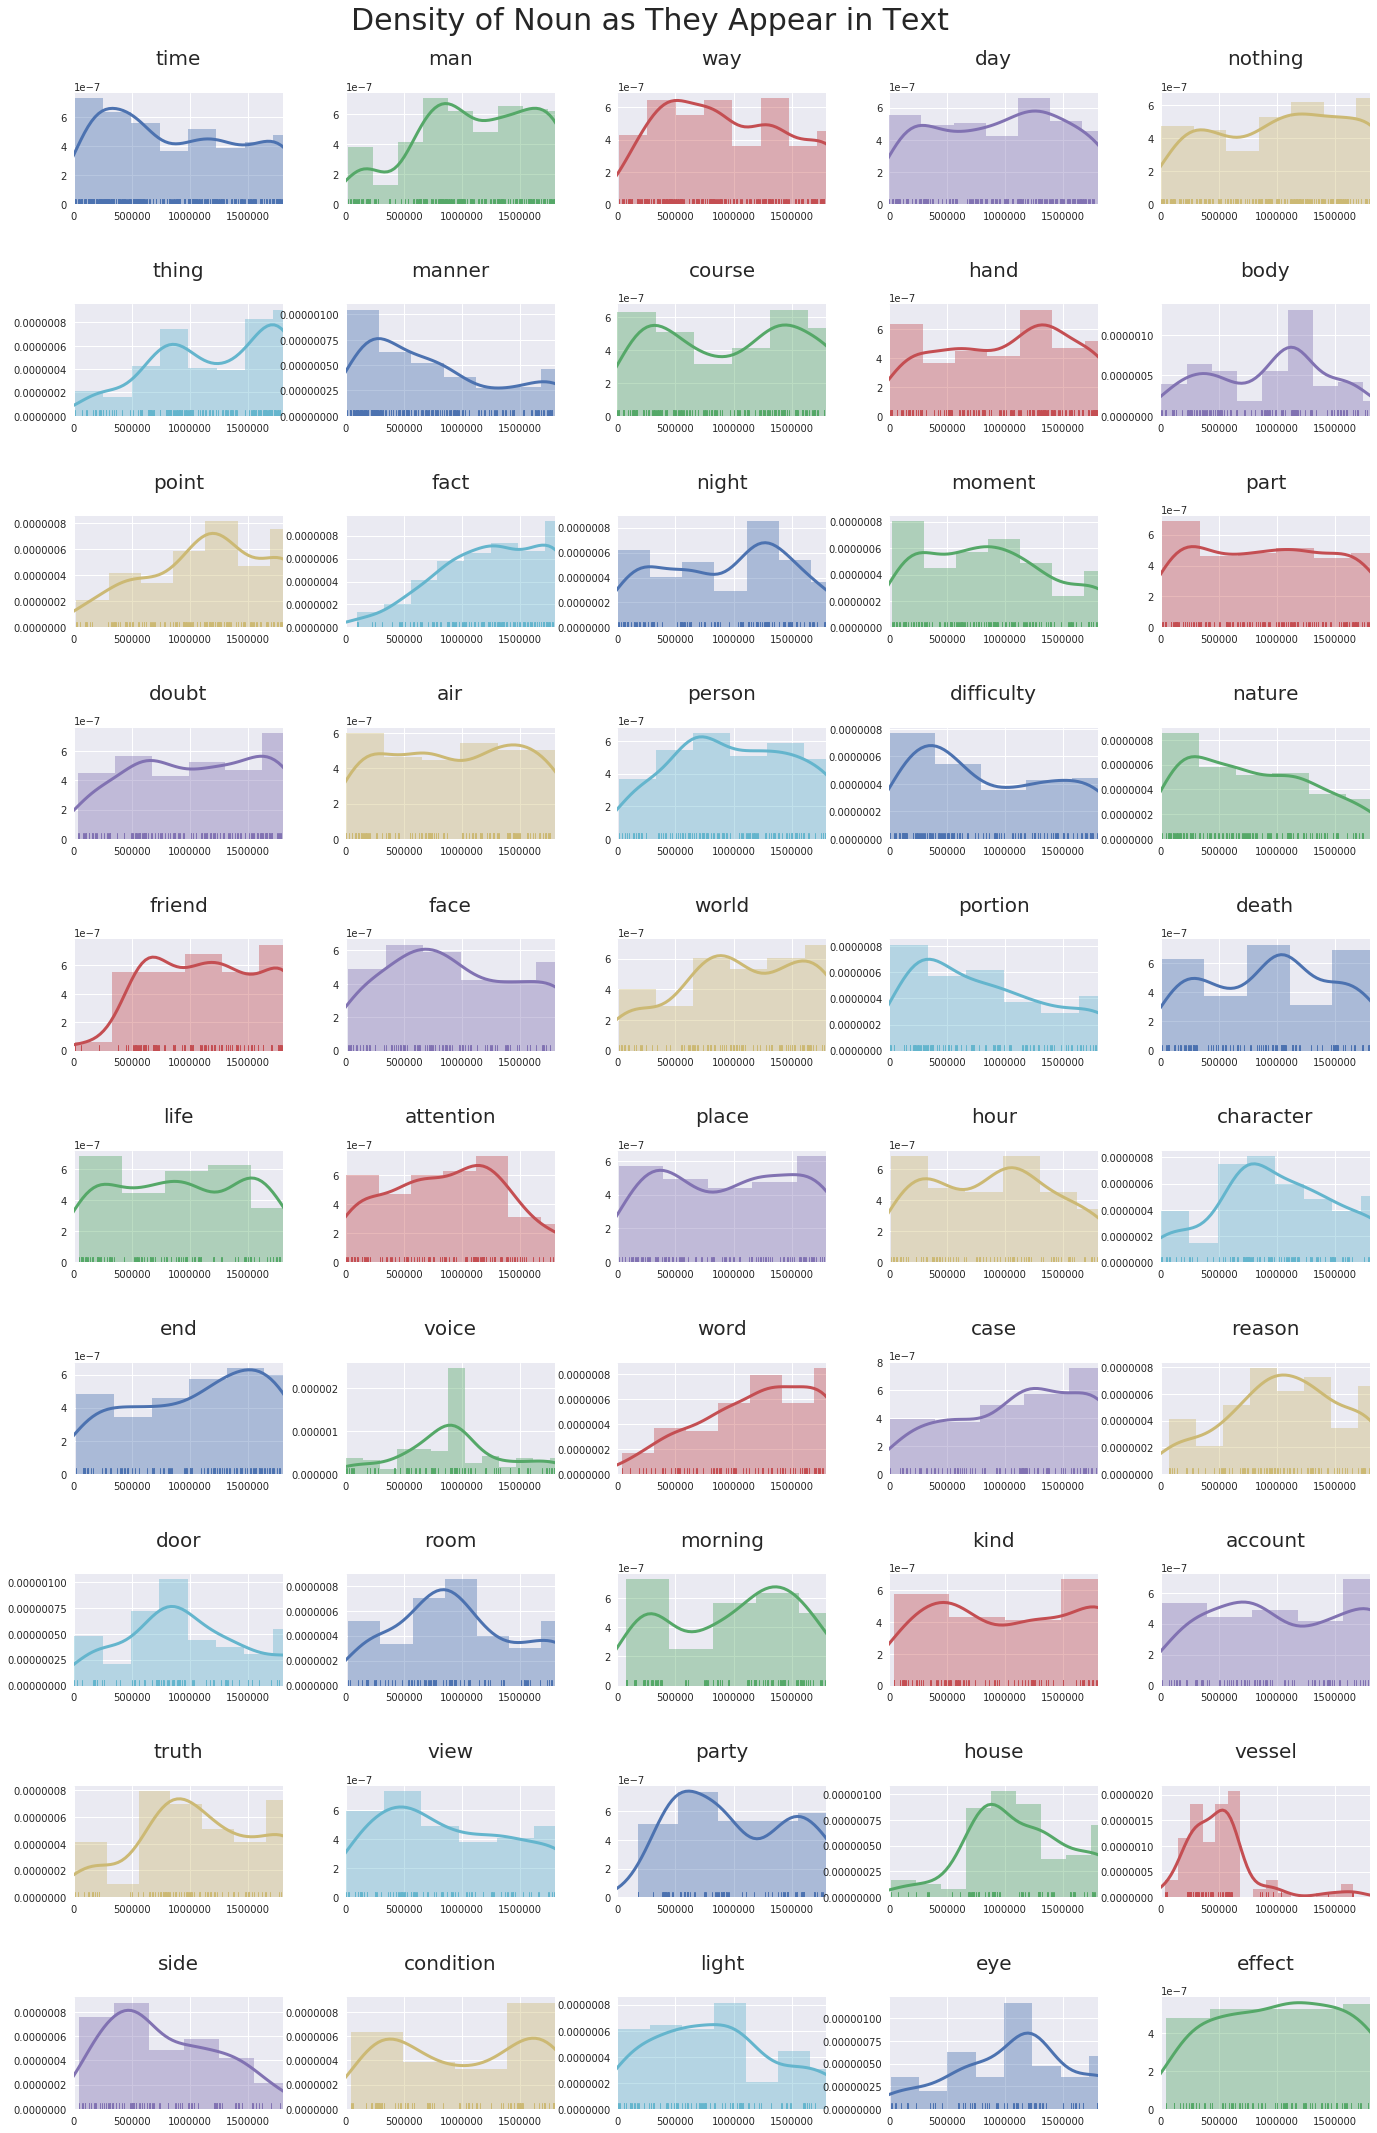

In [67]:
width = 5
drawPosWordDensityGraph(df, pos, width, amount)

<p>The density plots reveal that one word "vessel" seems to have a more isolated significance while others are more evenly distributed throughout the entirety of the works like "time", "nothing", and "part". Since the works were ordered by the date they were published, notable word frequency treands are evident, such as the word "fact's" frequecy is shown to increase over time while the word "nature" is shown to decrease. Before getting carried away with into correlation analysis between these sometimes all too generic nouns, first the adjectives that color them should be given some consideration.</p>

In [68]:
amount = 50
pos = 'adjective'
source = "works of edgar allen poe"
df = getPosWordCountDataframe(pos, amount)
drawPosWordCountsBarGraph(df, pos, amount, source)

<p>Again it seems the more generic a word the more often it is used within the text. But here, in the adjectives even more than the nouns, dichotomous pairing of the most used words is also evident. Some examples of these dichotomous pairs are: great-small, first-last, black-white, and young-old. Since every adjective is coupled with a noun it would be interesting to note how many of the top fifty adjectives are paired with the top fifty nouns. But first a look at the density distribution of the adjectives within the text.</p>

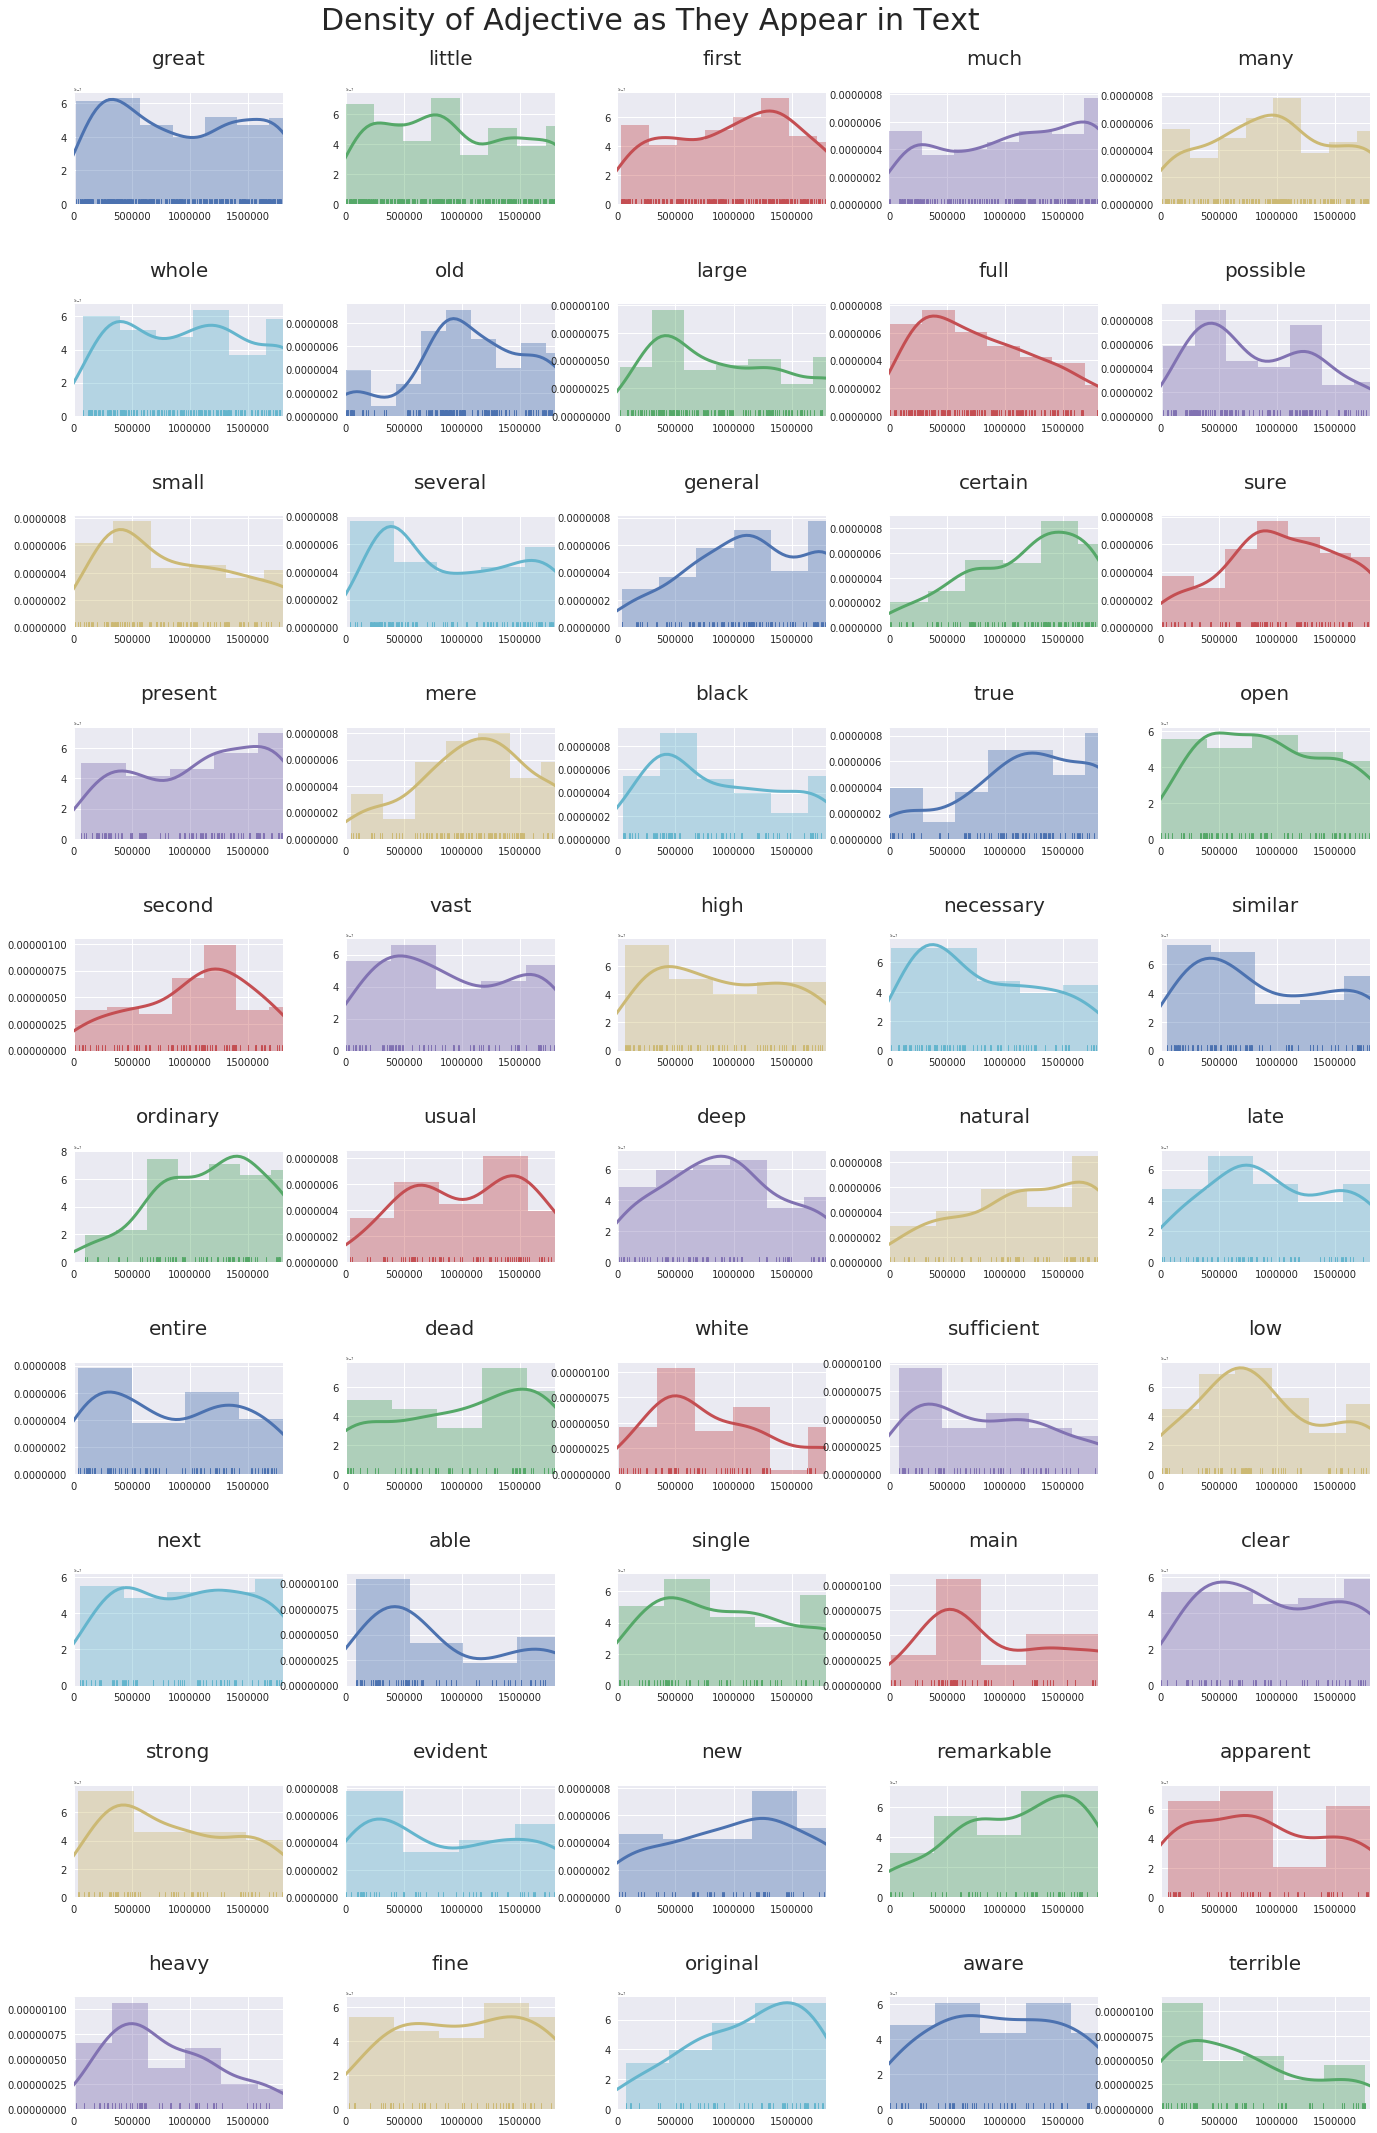

In [69]:
width = 5
drawPosWordDensityGraph(df, pos, width, amount)

Looking at the adjective density charts shows the same notion of a word being more specific to one story as opposed to that word being more generally used and gives evidence to some words trends in use over time, such words as "heavy" and "full" show clear decline while other words like "original" show increase in their use over time. Overall, it would seem that switching focus to look deeper in other directions such words pairings and sentiment analysis might reveal a more nuanced perpective of the data, but for the sake of completeness on to the verb data.

In [77]:
amount = 50
pos = 'verb'
source = "works of edgar allen poe"
df = getPosWordCountDataframe(pos, amount)
drawPosWordCountsBarGraph(df, pos, amount, source)

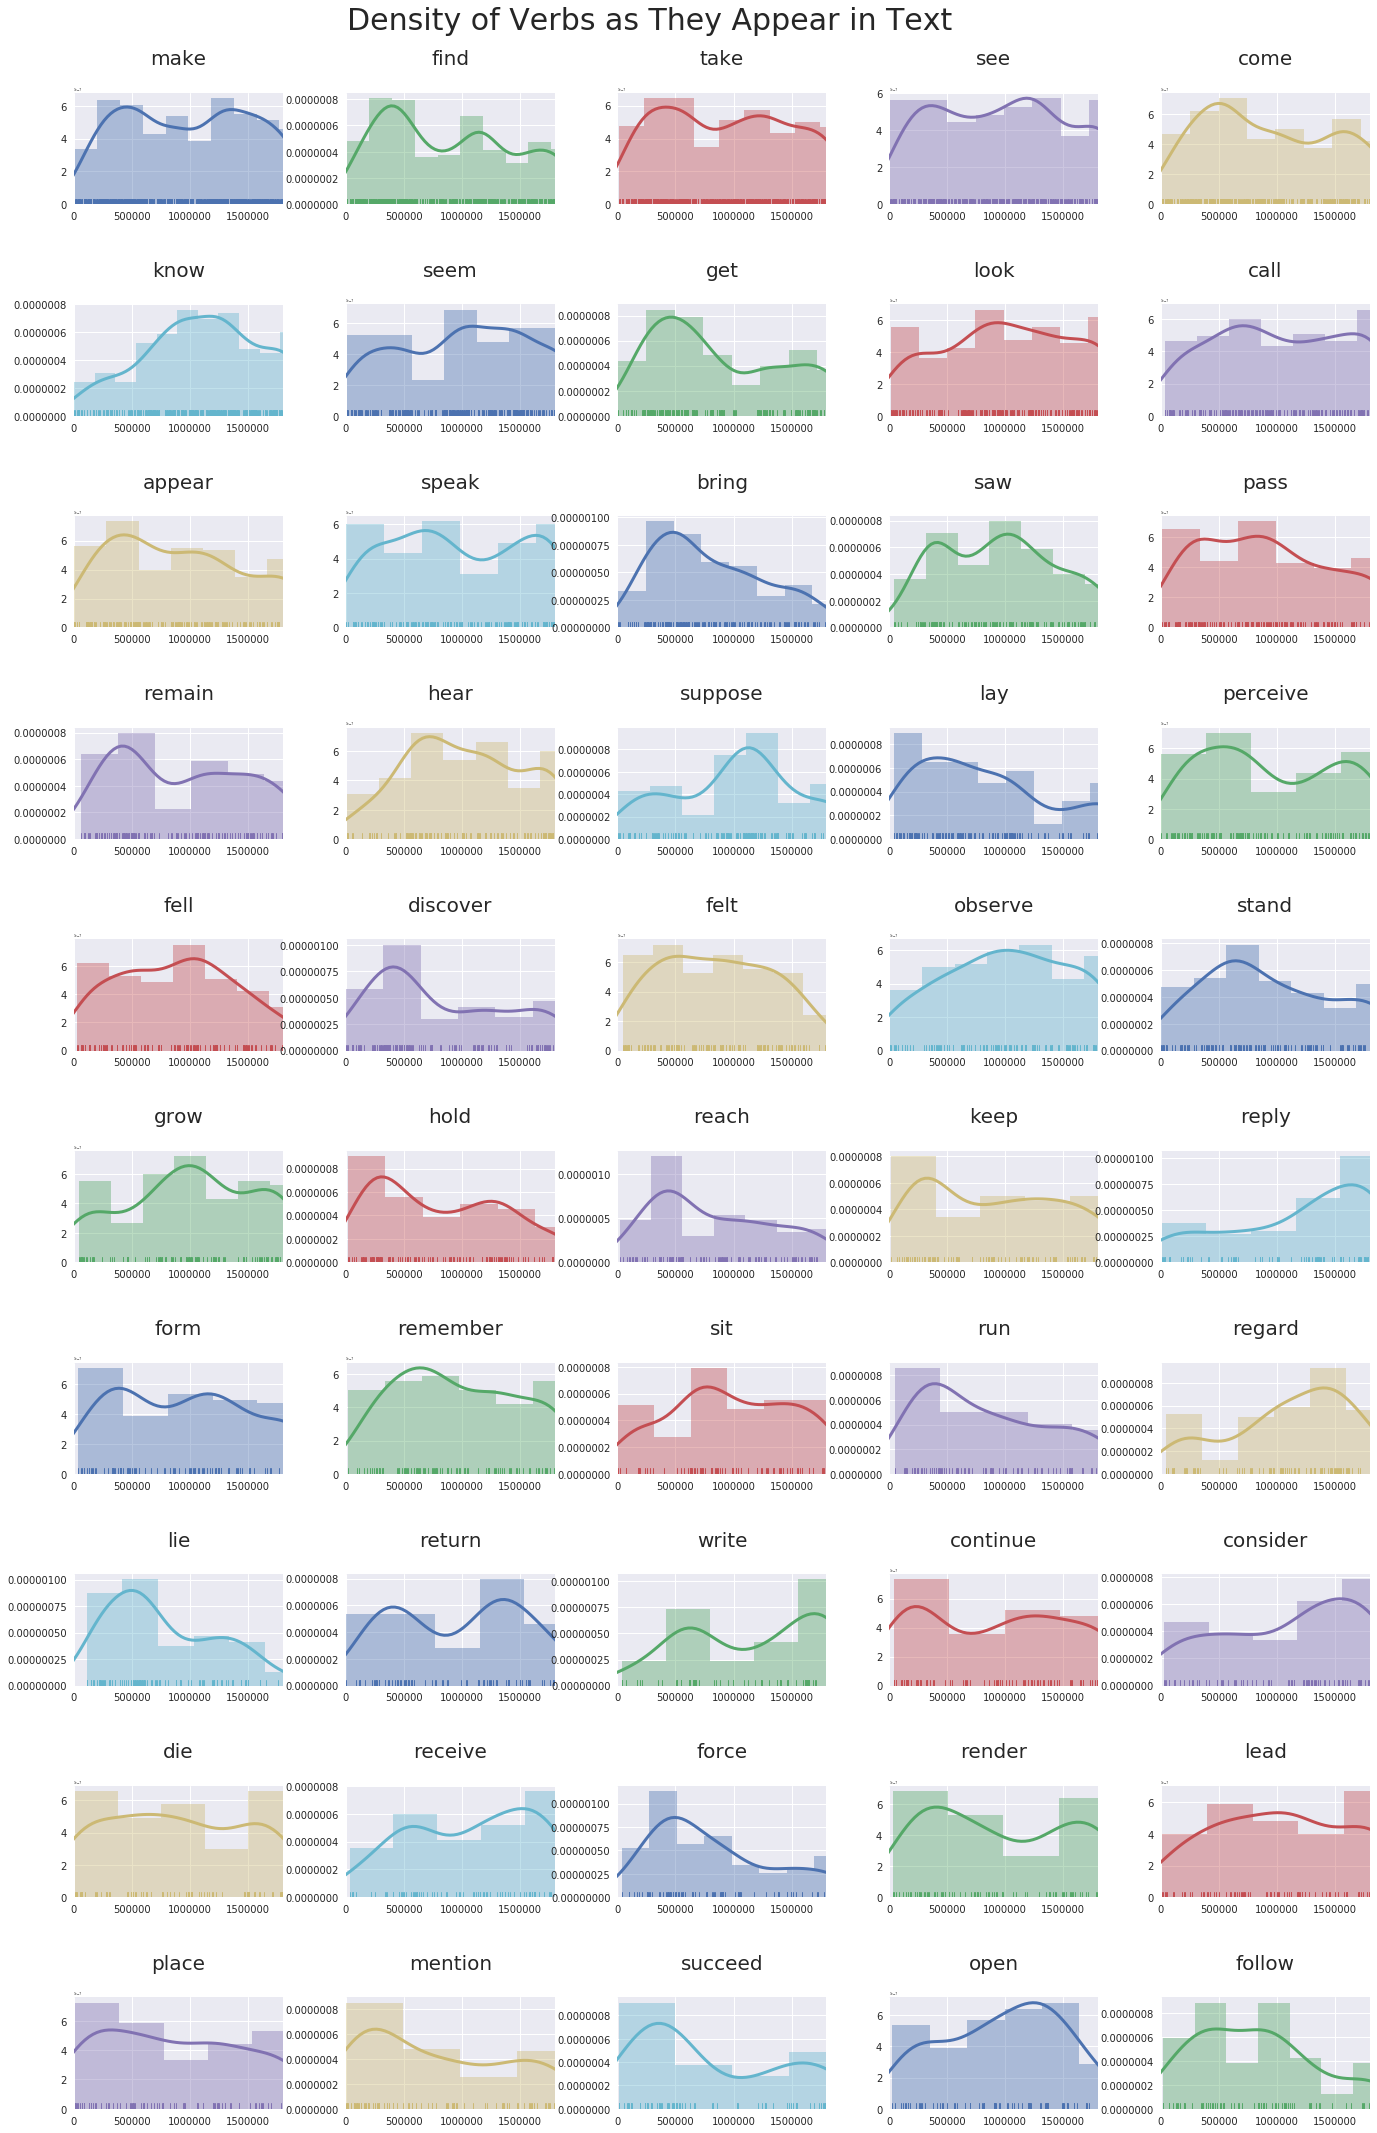

In [78]:
width = 5
drawPosWordDensityGraph(df, pos, width, amount)

In [79]:
amount = 50
pos = 'adverb'
source = "works of edgar allen poe"
df = getPosWordCountDataframe(pos, amount)
drawPosWordCountsBarGraph(df, pos, amount, source)

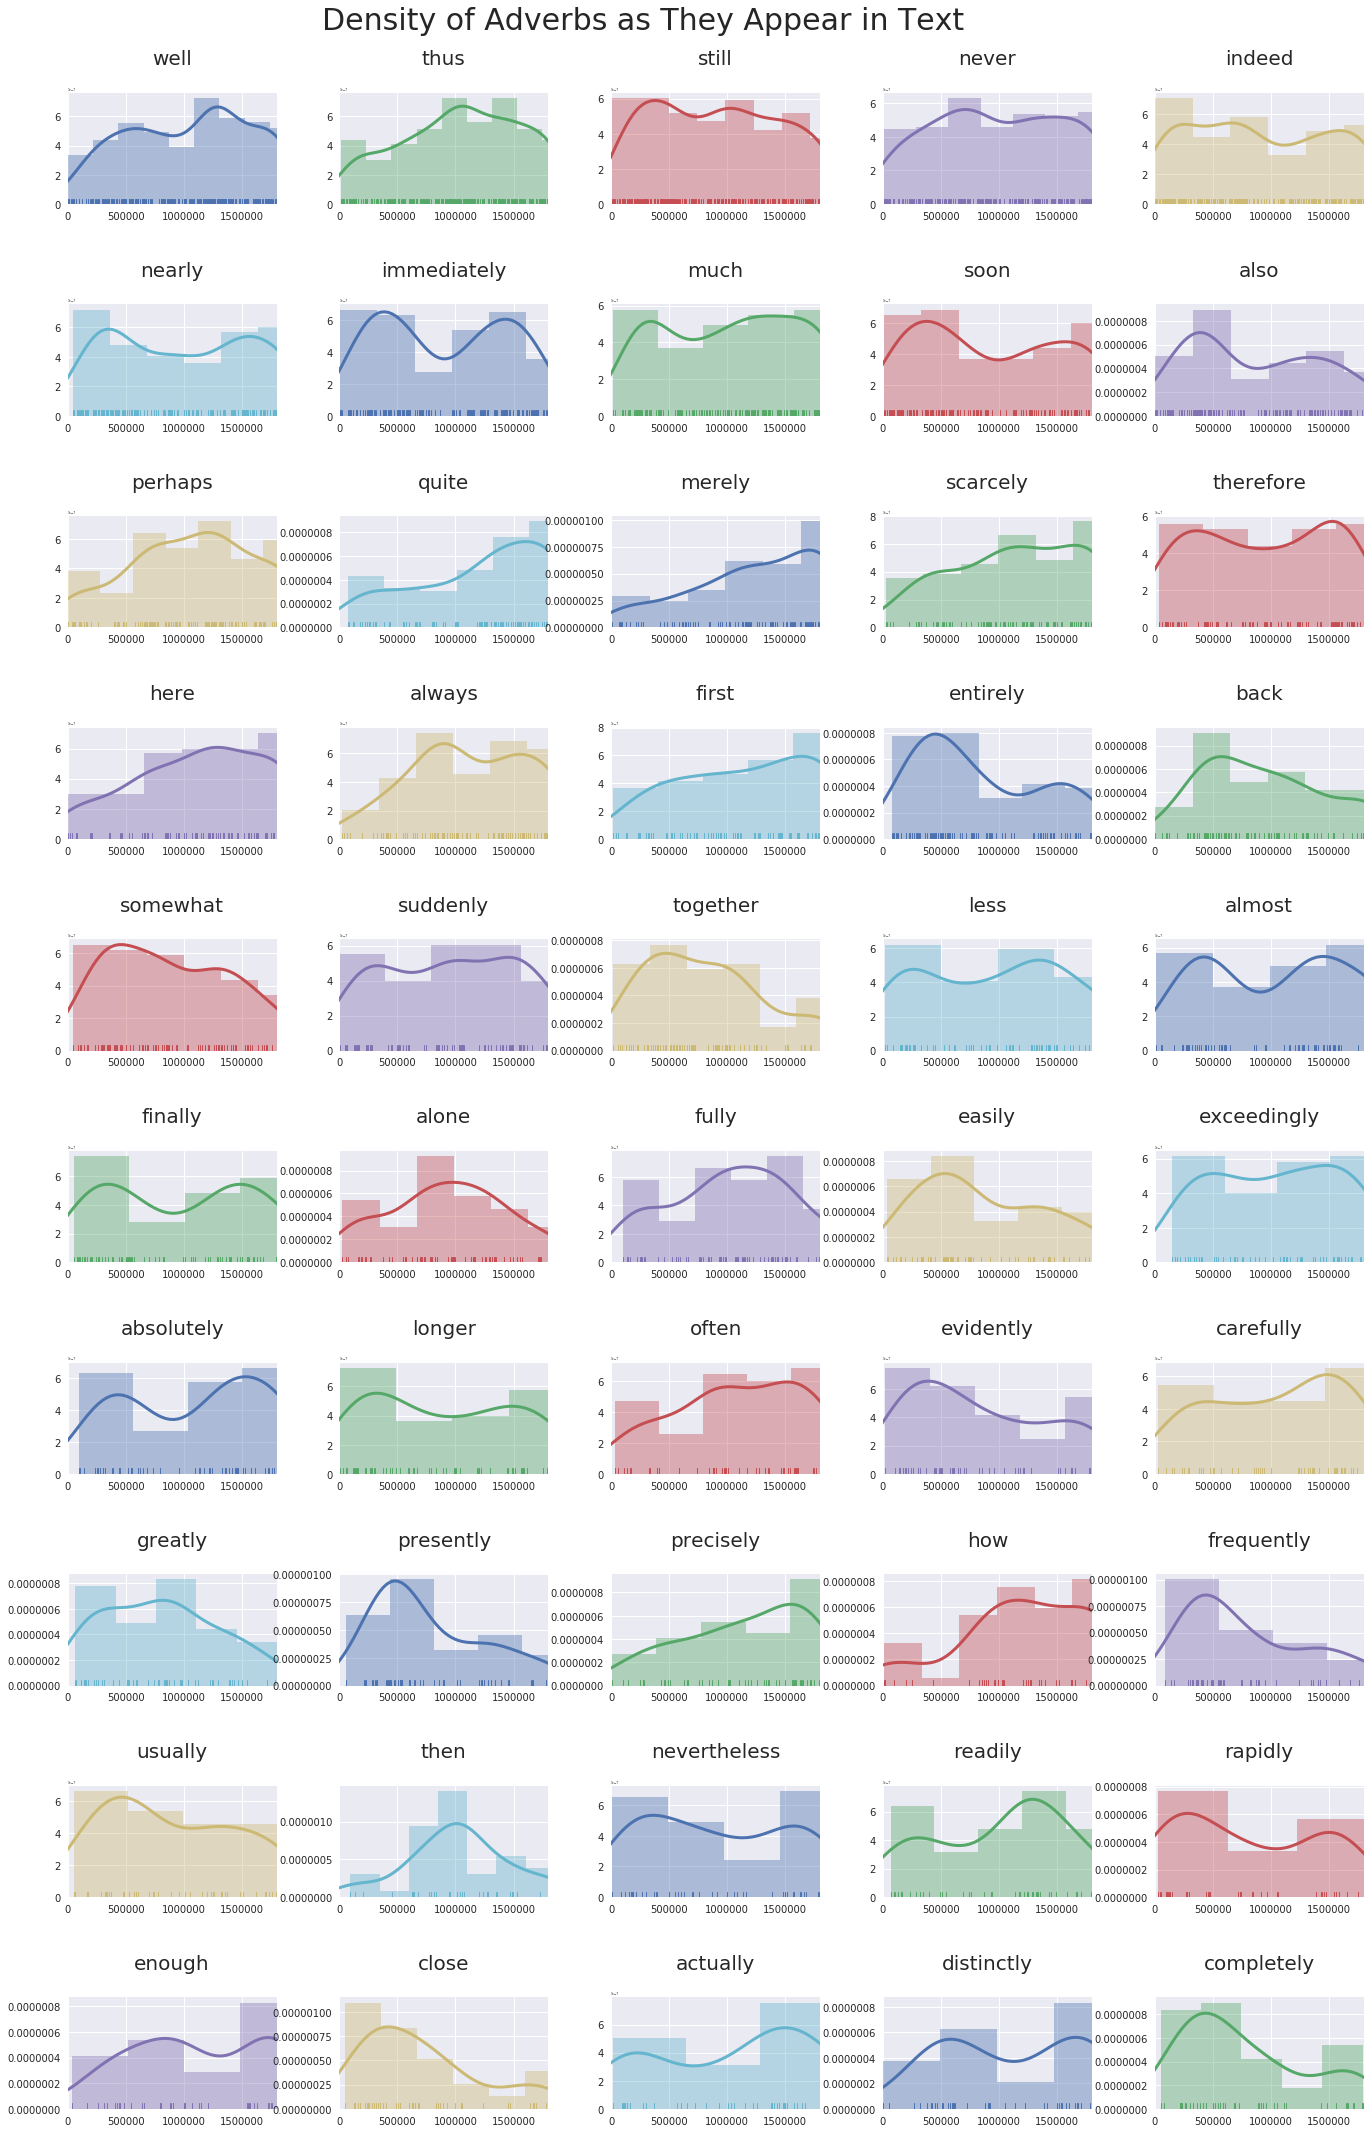

In [80]:
width = 5
drawPosWordDensityGraph(df, pos, width, amount)

In [70]:
all_noun = getPosWordCountDataframe("noun")


In [71]:
all_adjective = getPosWordCountDataframe("adjective")

In [72]:
# print(all_noun.head())
noun = all_noun.loc[all_noun.word =='man']
noun_adj_df = getWordPairings(noun, all_adjective)
print(noun_adj_df)

  noun   adjective  count                                 locations
0  man       great      2  [[1303638, 1303641], [1772702, 1772704]]
1  man        many      2  [[1042329, 1042331], [1714007, 1714009]]
2  man     general      2      [[696075, 696078], [974648, 974650]]
3  man         mad      2  [[1272403, 1272406], [1393376, 1393378]]
4  man  remarkable      2        [[18041, 18043], [203056, 203059]]
   noun    adjective  count                                 locations
0   man        great      2  [[1303638, 1303641], [1772702, 1772704]]
1   man         many      2  [[1042329, 1042331], [1714007, 1714009]]
2   man      general      2      [[696075, 696078], [974648, 974650]]
3   man          mad      2  [[1272403, 1272406], [1393376, 1393378]]
4   man   remarkable      2        [[18041, 18043], [203056, 203059]]
5   man         dark      2  [[1143333, 1143335], [1144340, 1144342]]
6   man    perturbed      1                        [[509125, 509128]]
7   man     abstract      1     

In [73]:
# print(noun_adj_df.loc[noun_adj_df.noun =='man'])
# print(noun_adj_df.loc[noun_adj_df.adjective =='great'])

In [74]:
# import spacy
# nlp = spacy.load('en')
# sent = "I shot an elephant"
# doc=nlp(sent)

# sub_toks = [tok for tok in doc if (tok.dep_ == "nsubj") ]

# print(sub_toks) 